データサイエンス特別PG データサイエンス特論 第10回 課題

In [1]:
# google colab で実行する場合は下記のコメントアウトを外して実行する
# ! wget https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx
# ! pip install japanize-matplotlib

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import datetime
import sklearn
import openpyxl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble  import RandomForestClassifier
from sklearn.metrics import f1_score
import seaborn as sns

In [3]:
# エクセルファイルを読み込み、データフレームに保存
weather_df = pd.read_excel('ds07_temp_power_exercise.xlsx', 
                           sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                           names=['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                           '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                           '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])

year = 2020
month = 1
data = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧'] 
target = '天気概況'
weather_data = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                        & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][data].values
weather_target = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                            & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][target].values

max_depth= 2
f1_score: 0.5483870967741935


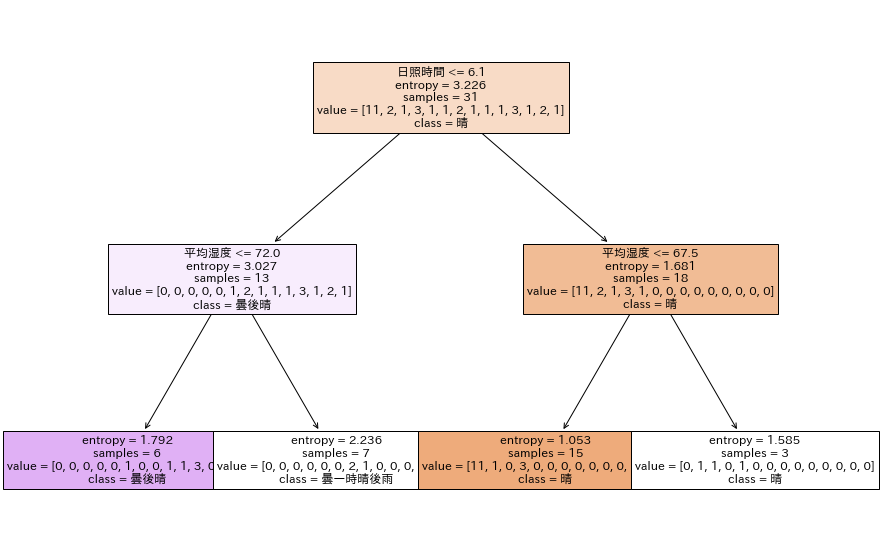

In [83]:
# 決定機を作成して表示
_depth = 2
clf = DecisionTreeClassifier(criterion='entropy', max_depth=_depth)
clf = clf.fit(weather_data, weather_target)
print('max_depth=', _depth)
print('f1_score:', f1_score(weather_target, clf.predict(weather_data), average="micro"))
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=data, class_names=weather_target, fontsize=12)

plt.show()

In [90]:
# 決定木の判断基準をテキストで表示
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 7 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 4] <= 6.1000001430511475 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 8] <= 72.0 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a split node: go to node 5 if X[:, 8] <= 67.5 else to node 6.
		node=5 is a leaf node.
		node=6 is a leaf node.


In [11]:
for i in range(1,10):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    clf = clf.fit(weather_data, weather_target)
    print('max_depth=', i, 
          'f1_score:', f1_score(weather_target, clf.predict(weather_data), average="micro"))


max_depth= 1 f1_score: 0.45161290322580644
max_depth= 2 f1_score: 0.5483870967741935
max_depth= 3 f1_score: 0.7096774193548389
max_depth= 4 f1_score: 0.9032258064516129
max_depth= 5 f1_score: 1.0
max_depth= 6 f1_score: 1.0
max_depth= 7 f1_score: 1.0
max_depth= 8 f1_score: 1.0
max_depth= 9 f1_score: 1.0


In [24]:
# ランダムフォレストを作成してF値を計算 (木の数、木の深さはグリッドサーチ) 
# f1_score が最も良いパラメータを出力、f1_score をリスト(_heatmap)に保存
_seed = 1
best_f1_score = 0
best_estimator = 0
best_depth = 0
best_params = []
_heatmap = []
for _depth in range(1,6):
    _heatmap_row = []
    for _estimator in range(1,51):
        rf = RandomForestClassifier(n_estimators=_estimator, max_depth=_depth, random_state=_seed)
        rf = rf.fit(weather_data, weather_target)
        _f1_score = f1_score(weather_target, rf.predict(weather_data), average="micro")
        _heatmap_row.append(_f1_score)
        if _f1_score > best_f1_score:
            best_f1_score = _f1_score
            best_estimator = _estimator
            best_depth = _depth
            if _f1_score == 1.0:
                best_params.append([_estimator, _depth])
    _heatmap.append(_heatmap_row)

print('random_seed=', _seed)
print(f'best n_estimators={best_estimator}')
print(f'best depth={best_depth}')
print(f'best f1_score={best_f1_score}')
print(f'params of f1_score=1.0 -> {best_params}')

random_seed= 1
best n_estimators=22
best depth=4
best f1_score=1.0
params of f1_score=1.0 -> [[22, 4]]


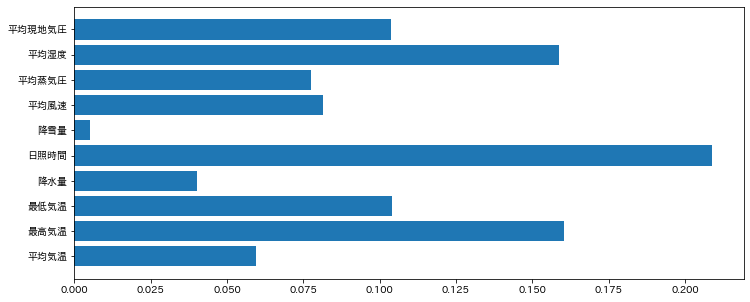

In [89]:
# 説明変数の重要度をグラフに出力
rf = RandomForestClassifier(n_estimators=22, max_depth=4, random_state=1)
rf = rf.fit(weather_data, weather_target)
importances = rf.feature_importances_
plt.figure(figsize=(12, 5))
plt.barh(range(len(data)), rf.feature_importances_ , align='center')
plt.yticks(np.arange(len(data)), data)
plt.show()

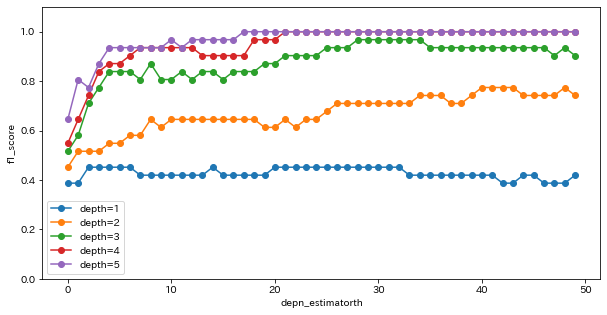

In [85]:
# 木の数、木の深さを変化させたときの f1_score を折れ線グラフで表示
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
ax1.plot(_heatmap[0], label="depth=1", marker='o')
ax1.plot(_heatmap[1], label="depth=2", marker='o')
ax1.plot(_heatmap[2], label="depth=3", marker='o')
ax1.plot(_heatmap[3], label="depth=4", marker='o')
ax1.plot(_heatmap[4], label="depth=5", marker='o')
ax1.set_xlabel("depn_estimatorth")
ax1.set_ylabel("f1_score")
ax1.set_ylim(0, 1.1)
ax1.legend()
plt.show()

<AxesSubplot:>

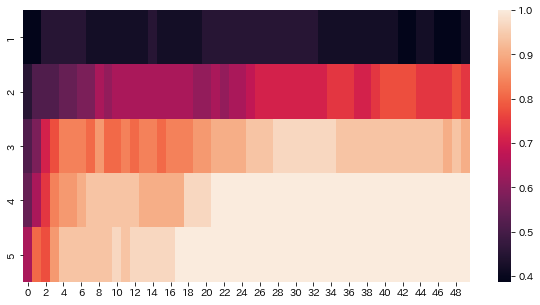

In [84]:
# 木の数、木の深さを変化させたときの f1_score をヒートマップで表示
fig = plt.figure(figsize=(10, 5))
_heatmap_df = pd.DataFrame(_heatmap, index=[1,2,3,4,5])
sns.heatmap(_heatmap_df)

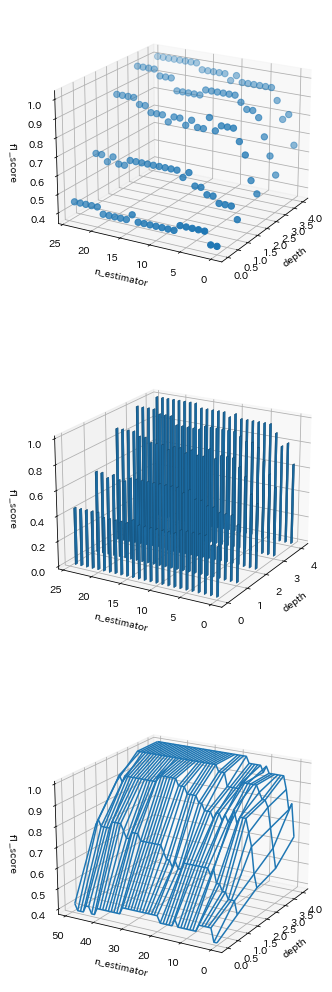

In [88]:
# 木の数、木の深さを変化させたときの f1_score をヒートマップで表示
x = []
y = []
z = []
for _depth in range(5):
    for _estimator in range(25):
        x.append(_depth)
        y.append(_estimator)
        z.append(_heatmap[_depth][_estimator])

fig = plt.figure(figsize=(6, 18))
ax1 = fig.add_subplot(311, projection='3d')
ax1.scatter(x, y, z, s=40)
ax1.set_xlabel("depth")
ax1.set_ylabel("n_estimator")
ax1.set_zlabel("f1_score")
ax1.view_init(20, 210)

ax2 = fig.add_subplot(312, projection='3d')
ax2.bar3d(x, y, 0, 0.1, 0.1, z)
ax2.set_xlabel("depth")
ax2.set_ylabel("n_estimator")
ax2.set_zlabel("f1_score")
ax2.view_init(20, 210)

_X = np.array(range(5))
_Y = np.array(range(50))
X, Y = np.meshgrid(_X, _Y)
Z = np.array(_heatmap).T
ax3 = fig.add_subplot(313, projection='3d')
ax3.plot_wireframe(X, Y, Z)
ax3.set_xlabel("depth")
ax3.set_ylabel("n_estimator")
ax3.set_zlabel("f1_score")
ax3.view_init(20, 210)

plt.show()

In [82]:
# n_estimator = 1 で作成したランダムフォレストは決定木と同じ結果を出すか？
_depth = 5
_n_estimator = 1
_seed = 1

clf = DecisionTreeClassifier(criterion='entropy', max_depth=_depth)
clf = clf.fit(weather_data, weather_target)
print('決定木: max_depth=', _depth, 
        'f1_score:', f1_score(weather_target, clf.predict(weather_data), average="micro"))

rf = RandomForestClassifier(n_estimators=_n_estimator, max_depth=_depth, random_state=_seed)
rf = rf.fit(weather_data, weather_target)
print('ランダムフォレスト: max_depth=', _depth, 
        'f1_score:', f1_score(weather_target, rf.predict(weather_data), average="micro"))

決定木: max_depth= 5 f1_score: 1.0
ランダムフォレスト: max_depth= 5 f1_score: 0.6451612903225806
